# Configurações

Imports de Pacotes

In [13]:
#pip install --upgrade "ibm-watson>=4.0.1"

Requirement already up-to-date: ibm-watson>=4.0.1 in /usr/local/lib/python3.6/dist-packages (4.5.0)


In [16]:
from IPython.display import display, Javascript
from IPython.display import Image
from google.colab.output import eval_js
from base64 import b64decode
import json
from ibm_watson import VisualRecognitionV3
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator

In [22]:
#https://cloud.ibm.com/
#Serviço: VisualRecognitionV3
#Get authenticator in Service credentials
authenticator = IAMAuthenticator('7JLj77cJlAoFi0185S8vy9cp8pcsiCmrEZqVFSbLtDKR')

In [27]:
#dont change version
visual_recognition = VisualRecognitionV3(
    version='2018-03-19',
    authenticator=authenticator
)

In [28]:
visual_recognition.set_service_url("https://api.us-south.visual-recognition.watson.cloud.ibm.com/instances/e606bf88-2faf-4bd4-9425-90c9f02b16b8")

In [ ]:
#Classificar Imagem em um Link
#url = 'https://ibm.biz/BdzLPG'
#classes_result = visual_recognition.classify(url=url).get_result()
#print(json.dumps(classes_result, indent=2))

In [43]:
#Classificar imagem em um arquivo no local
#with open('terno.jpg', 'rb') as images_file:
#  classes_result = visual_recognition.classify(images_file=images_file).get_result()
#  print(json.dumps(classes_result, indent=2))

Funções úteis

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

# Informações do cliente

In [ ]:
#@title Preencha aqui com as informações do cliente requisitante

#@markdown Informe todos os campos a seguir:
nome = "Informe aqui o nome" #@param {type:"string"}

renda = 1000.00 #@param {type:"number"}
idade = 18 #@param {type:"slider", min:18, max:100, step:1}
etnia = "Selecionar etnia"  #@param ["Selecionar etnia", "Etnia01", "Etnia02"]
genero = "Feminino" #@param ["Masculino", "Feminino"]
casa_propria = "Selecionar" #@param ["Selecionar", "Sim", "Não"]
outras_rendas = "Selecionar" #@param ["Selecionar", "Sim", "Não"]
estado_civil = "Selecionar" #@param ["Selecionar", "Estado01", "Estado02"]
escolaridade = 1 #@param {type:"slider", min:0, max:3, step:1}

#@markdown ---


<IPython.core.display.Javascript object>

Saved to photo.jpg


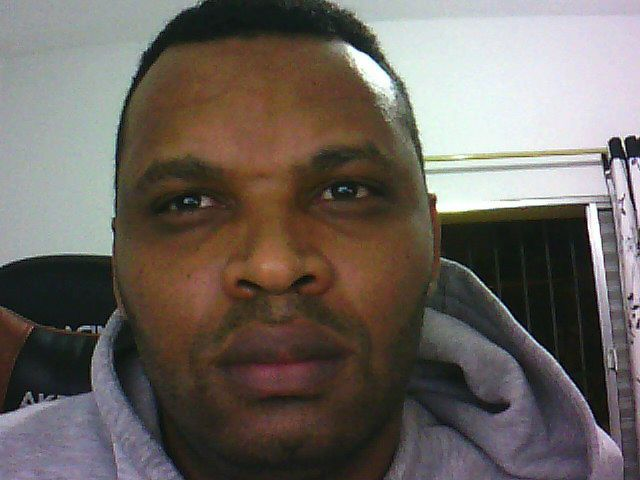

In [48]:
#@title Tire uma foto do cliente requerente (ou tire uma foto sua mesmo)

try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

# Análise de crédito

1. Verifique se na imagem possui uma pessoa, utilizando a API "default" da IBM; Se não possuir, informar mensagem e não conceder o empréstimo.


2.  Verifique se a imagem apresenta conteúdo explícito , utilizando a API "explicit"da IBM; Se possuir, informar mensagem e não conceder o empréstimo.  


3. Verificar o gênero e a idade da pessoa utilizando a API de reconhecimento facial da Microsoft Azure; Se não for o mesmo gênero ou se a idade diferir em 5 anos (para mais ou para menos), informar mensagem e não conceder o empréstimo.


4. Exibir a imagem novamente no notebook com os pontos "fiduciais" da face da pessoa, obtidos pela API da Azure. (em uma aplicação corporativa, estes pontos ficam gravados para futuras autenticações)


5. Chamar a API de Machine Learning em um contêiner feito em Docker e que esteja rodando em uma máquina virtual no Google Cloud. Esta API deve usar os dados informados neste notebook e **automaticamente** vetar ou conceder o empréstimo.


ATENÇÃO PARA O BULLET 5: É necessário chamar tanto um modelo que possua a variável ETNIA quanto um modelo que não possui esta variável, assim como fizemos em aula!!!


6. Gravar um vídeo "operando" o notebook e simulando a avaliação com concessão ou reprovação do crédito.


7. Submeter o Notebook e o vídeo da plataforma da FIAP, se o vídeo ficar muito grande, submeter ao Youtube (pode ser privado) e anexar o Link.

---  
(Dica: Você pode usar este vídeo para divulgar seu trabalho como Engenheiro de ML)


In [191]:
#Melhorar essa função, deve ter uma maneira mais pythonica de recuperar a classe de dentro do json.
def analysePicture(visual_recognition,urlPicture,threshold=0.7,classifier_ids="default"):
  '''
    Description:
      Função de Analise de Imagem utilizando a API Visual Recognition da IBM
      Verifica se a foto é de uma pessoa e se não possui conteúdo explícito

    Parameters:
      visual_recognition
        Objeto VisualRecognitionV3 já instânciado
      urlPicture
        URL da Imagem
      threshold
        Percentural de acurácia que a analise deve atingir para que a função tenha 
        um retorno positivo
      classifier_ids - API utilizada (default ou explicit) 
      
  '''

  foundClass = False

  if classifier_ids == "explicit":
    class_picture = "explicit"
  else: 
    class_picture = "person"

  with open(urlPicture, 'rb') as images_file:
    classes_result = visual_recognition.classify(images_file=images_file,threshold=threshold,classifier_ids=classifier_ids).get_result()

  classes = classes_result['images'][0]['classifiers'][0]['classes']
  
  for classe in classes:
    if classe.get("class") == class_picture:
      foundClass = True
      exit

  return foundClass

In [193]:
#Teste da Função analysePicture
lPictureOK = False

#Analisa se a foto é de uma pessoa
if analysePicture(visual_recognition,"photo.jpg"):
  #Analisa se a foto possui conteudo explicito
  #testar com alguma foto "pesada" kkkkk
  if not (analysePicture(visual_recognition,"photo.jpg",0.75,"explicit")):
    lPictureOK = True
  
if lPictureOK:
  print("Foto Aprovada")
else:
  print("Foto Recusada")

Foto Aprovada
